In [1]:
import itertools
import os

import jax
import jax.numpy as jnp
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.collections as mcoll
import matplotlib.patches as mpatches

params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

from fbpinns.domains import RectangularDomainND
from fbpinns.networks import FCN, SIREN
from fbpinns.trainers import get_inputs, FBPINN_model_jit
from fbpinns.analysis import load_model
from fbpinns.util.logger import logger
from fbpinns.util.jax_util import tree_index
logger.setLevel("CRITICAL")

from problems import Laplace1D_quadratic, Laplace2D_quadratic, Laplace2D_multiscale, Helmholtz2D
from plot import load_FBPINN, load_PINN, exact_solution, FBPINN_solution, PINN_solution

In [2]:
def fix_plot(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Normalised L1 test loss")

def fix_plot3(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Total time elapsed (s)")
    plt.ylabel("Normalised L1 test loss")

def fix_plot2():
    plt.xlabel("$x_1$", fontsize="large")
    plt.ylabel("$x_2$", fontsize="large")
    plt.xlim(0,1); plt.ylim(0,1)
    
def fix_plot4():
    plt.xticks([]); plt.yticks([])
    plt.xlim(0,1); plt.ylim(0,1)

def savefig():
    plt.savefig(f"plots/{problem.__name__}-{tag}.pdf", bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

colors1 = cm.Blues(np.linspace(0.2,0.95,6))
colors2 = cm.Greens(np.linspace(0.2,0.95,6))
colors3 = cm.Reds(np.linspace(0.2,0.95,6))
colors4 = cm.Greys(np.linspace(0.2,0.95,6))
colorss = [colors1, colors2, colors3]

## Laplace - 1D/2D schematic

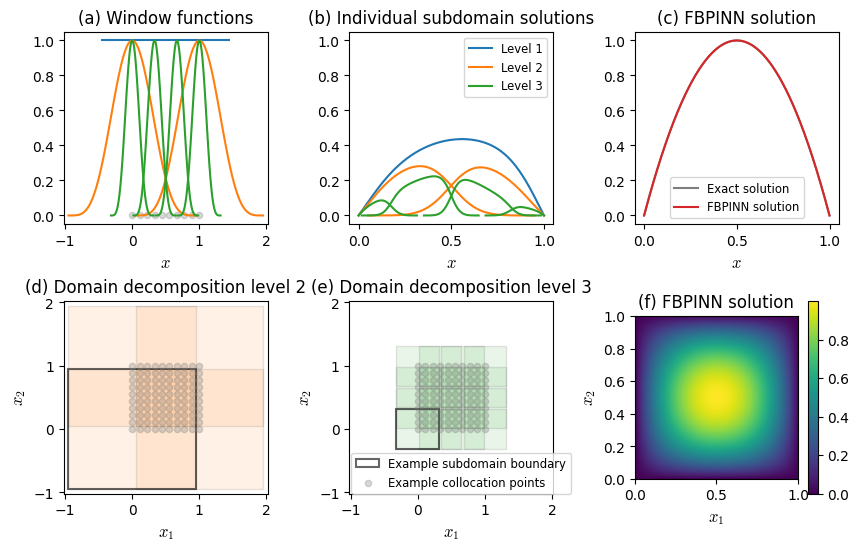

In [3]:
network = FCN
tag = "ablation"
problem=Laplace1D_quadratic
w, h, p = 1.9,1,16
l = [2**i for i in range(3)]
n = (80,)


c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
u_exact = exact_solution(c, model)

all_params, active = model[1], model[3]
domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network
model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)

x_batch = x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)

takes, all_ims, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, decomposition)
    
# get FBPINN solution using test data
all_params_cut = {"static":cut_all(all_params["static"]),
                  "trainable":cut_all(all_params["trainable"])}
u_test, wp_test_, us_test_, ws_test_, us_raw_test_ = FBPINN_model_jit(all_params_cut, x_batch_test, takes, model_fns, verbose=False)

m, ud, n = all_params["static"]["decomposition"]["m"], all_params["static"]["problem"]["dims"][0], x_batch_test.shape[0]

us_test = jnp.full((m, n, ud), jnp.nan)
us_test = us_test.at[all_ims[takes[0]], takes[1], :].set(us_test_)

ws_test = jnp.full((m, n, 1), jnp.nan)
ws_test = ws_test.at[all_ims[takes[0]], takes[1], :].set(ws_test_)

us_raw_test = jnp.full((m, n, ud), jnp.nan)
us_raw_test = us_raw_test.at[all_ims[takes[0]], takes[1], :].set(us_raw_test_)

# apply POU
us_test = us_test.at[all_ims[takes[0]], takes[1], :].divide(wp_test_[takes[2]])/takes[4]
ws_test = ws_test.at[all_ims[takes[0]], takes[1], :].divide(wp_test_[takes[2]])/takes[4]

# apply constraining operator
us_test = vmap(model_fns[-1], in_axes=(None,None,0))(all_params, x_batch_test, us_test)


x_batch_ = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(10,))

cs = ["tab:blue", "tab:orange", "tab:green"]
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
for im in range(all_params["static"]["decomposition"]["m"]):
    params_ = {"static":{"decomposition":{"subdomain":
                tree_index(all_params["static"]["decomposition"]["subdomain"], im)}}}
    xmin, xmax, wmin, wmax, *_ = params_["static"]["decomposition"]["subdomain"]["params"]
    x = np.linspace(xmin[0], xmax[0], 100).reshape((-1,1))
    w = jax.vmap(decomposition.window_fn, in_axes=(None,0))(params_, x)
    plt.plot(x, w, color=cs[all_params["static"]["decomposition"]["subdomain"]["pou"][im,0].astype(int)])
plt.scatter(x_batch_, jnp.zeros_like(x_batch_), s=20, alpha=0.3, c="tab:grey")
plt.xlim(-1.02, 2.02)
plt.title("(a) Window functions")
plt.xlabel("$x$", fontsize="large")
plt.subplot(2,3,3)
plt.plot(x_batch, u_exact, label="Exact solution", color="tab:grey")
plt.plot(x_batch, u_test, label="FBPINN solution", color="tab:red")
plt.title("(c) FBPINN solution")
plt.xlabel("$x$", fontsize="large")
ylim = plt.ylim()
plt.legend(fontsize="small")
plt.subplot(2,3,2)
for im,u in enumerate(us_test):
    il = all_params["static"]["decomposition"]["subdomain"]["pou"][im,0].astype(int)
    label,c = f"Level {il+1}", cs[il]
    if im not in [0,1,5]: label=None
    plt.plot(x_batch, u, color=c, label=label)
#plt.plot(x_batch, jnp.nansum(us_test, axis=0), lw=4,label="test", zorder=-10)
plt.title("(b) Individual subdomain solutions")
plt.legend(fontsize="small")
plt.xlabel("$x$", fontsize="large")
plt.ylim(ylim)





network = FCN
tag = "ablation"
problem=Laplace2D_quadratic
w, h, p = 1.9,1,16
l = [2**i for i in range(3)]
n = (80,80)


c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
u_test = FBPINN_solution(c, model)

all_params, active = model[1], model[3]
domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network

xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
xmins, xmaxs, wmins, wmaxs, *_ = all_params["static"]["decomposition"]["subdomain"]["params"]


x_batch_ = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(10,10))

plt.subplot(2,3,4)
patches = []
for i in range(1,5):
    patches.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                                     ))
    if i == 1:
        r = mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                               facecolor="none",
                               linewidth=1.5,
                               alpha=0.6,
                               edgecolor="k",
                                     )
plt.gca().add_collection(mcoll.PatchCollection(patches,
                                               alpha=0.1,
                                               edgecolor="k",
                                               facecolor="tab:orange"))
plt.gca().add_patch(r)
plt.scatter(x_batch_[:,0], x_batch_[:,1], s=20, alpha=0.3, c="tab:grey")
plt.xlim(-1.02, 2.02)
plt.ylim(-1.02, 2.02)
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(d) Domain decomposition level 2")
plt.subplot(2,3,5)
patches = []
for i in range(5,21):
    patches.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                                     ))
    if i == 5:
        r = mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                               facecolor="none",
                               linewidth=1.5,
                               alpha=0.6,
                               edgecolor="k",
                               label="Example subdomain boundary"
                                     )
plt.gca().add_collection(mcoll.PatchCollection(patches,
                                               alpha=0.1,
                                               edgecolor="k",
                                               facecolor="tab:green"))
plt.gca().add_patch(r)
plt.scatter(x_batch_[:,0], x_batch_[:,1], s=20, alpha=0.3, c="tab:grey", label="Example collocation points")
plt.xlim(-1.02, 2.02)
plt.ylim(-1.02, 2.02)
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(e) Domain decomposition level 3")
plt.legend(loc=(0.01,0), fontsize="small")
plt.subplot(2,3,6)
plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(f) FBPINN solution")

plt.subplots_adjust(hspace=0.4, wspace=0.4)
problem=Laplace1D_quadratic; tag = "domain"
savefig()
plt.show()

## Laplace - ablation tests

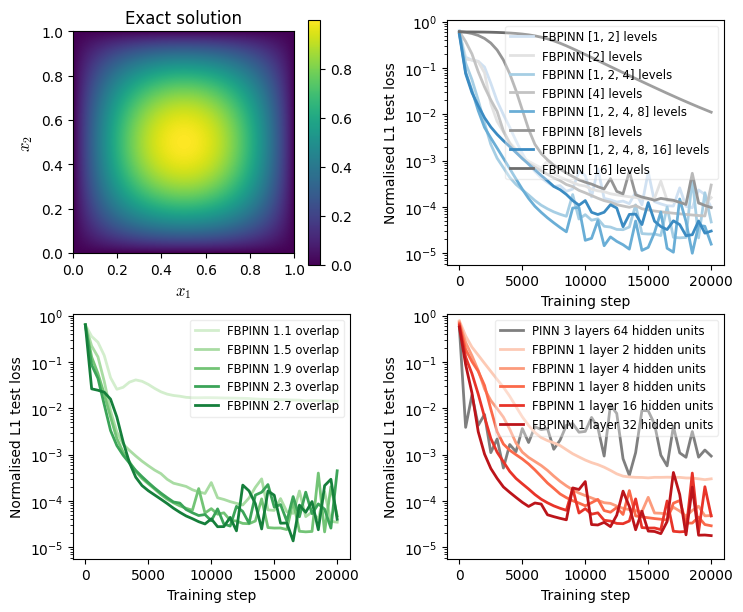

In [4]:
#########

network = FCN

## TEST 1: simple ablation tests
tag = "ablation"

# Laplace1D_quadratic ablation
domain=RectangularDomainND
domain_init_kwargs=dict(xmin=np.array([0.,]),
                        xmax=np.array([1.,]),)
problem=Laplace1D_quadratic
problem_init_kwargs=dict()
unnorm=(0.5, 0.375)# unnorm

n_steps=20000# number training steps
n=(80,)# number training points
n_test=(350,)# number test points

h=1

ls=[2, 3, 4, 5]# number of levels
ws=[1.1, 1.5, 1.9, 2.3, 2.7]# overlap width
ps=[2, 4, 8, 16, 32]# number of hidden units
p0=[3, 1.9, 16]

# Laplace2D_quadratic ablation
domain=RectangularDomainND
domain_init_kwargs=dict(xmin=np.array([0.,0]),
                        xmax=np.array([1.,1.]),)
problem=Laplace2D_quadratic

n=(80,80)# number training points
n_test=(350,350)# number test points

#########



# plot ablations
plt.figure(figsize=0.7*np.array([12,10]))

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,2)
for ip,l_ in enumerate(ls):
    l = [2**i for i in range(l_)]
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {l} levels ", c=colors1[ip], lw=2)
    if l_ != 0:
        l = [2**(l_-1)]
        c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
        plt.plot(i, l1, label=f"FBPINN {l} levels ", c=colors4[ip], lw=2)
    
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
ylim = list(plt.ylim())
ylim[0] -= 1e-7
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,3)
for ip,w in enumerate(ws):
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {w} overlap", c=colors2[ip], lw=2)
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,4)
h,p=3,64
c, model, i, t, l1 = load_PINN(tag, problem, network, h, p, n)
plt.plot(i, l1, label=f"PINN {h} layers {p} hidden units", c="tab:grey", lw=2)
h,p=1,16

for ip,p in enumerate(ps):
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {h} layer {p} hidden units", c=colors3[ip], lw=2)

fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

# plot exact solution
plt.subplot(2,2,1)
u_exact = exact_solution(c, model)
plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.title("Exact solution")
fix_plot2()

plt.subplots_adjust(hspace=0.2, wspace=0.35)
savefig()
plt.show()

## Laplace - strong scaling

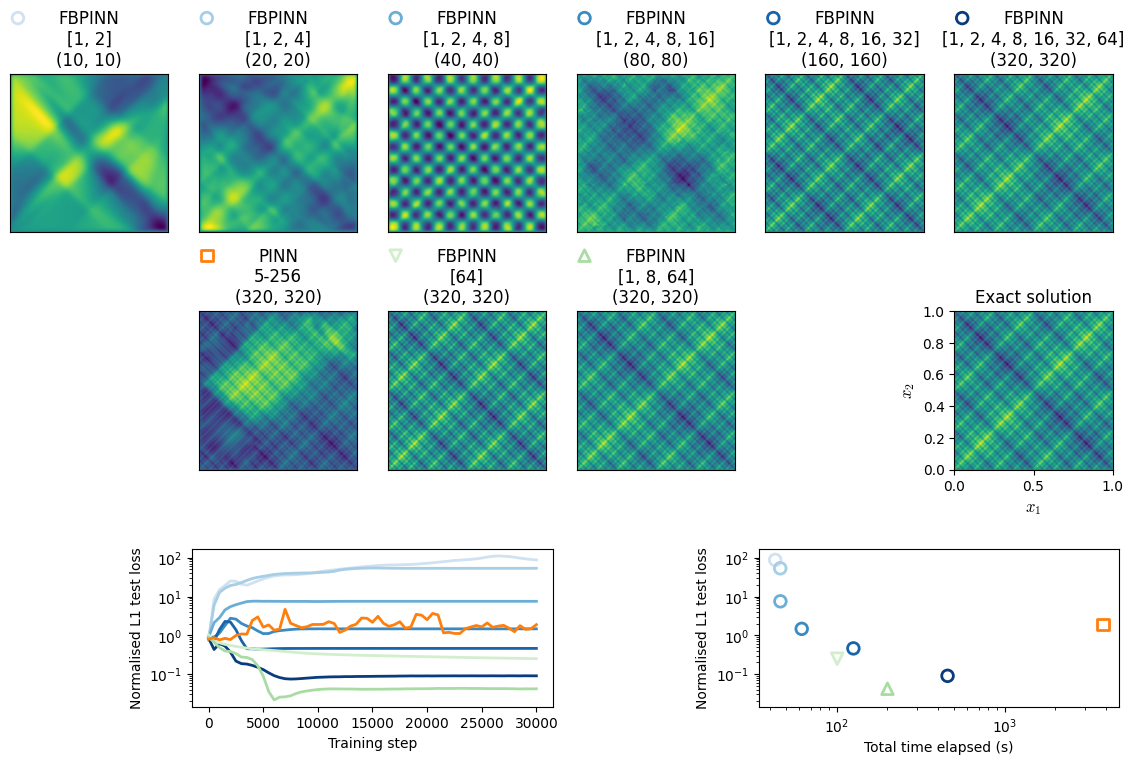

In [5]:
#########

## TEST 2: strong / weak scaling tests

# Laplace2D_multiscale strong scaling
tag = "strong"

problem=Laplace2D_multiscale
omegas=[2, 4, 8, 16, 32, 64]
unnorm=(0., 0.75)# unnorm

n_steps=30000# number training steps
n_test=(350,350)# number test points

h=1
w=1.9
p=16

# increase levels and collocation points
ls=[2, 3, 4, 5, 6, 7]# number of levels
ns=[(10,10),(20,20),(40,40),(80,80),(160,160),(320,320)]# number of collocation points

#########


# plot setup
plt.figure(figsize=0.72*np.array([20,20]))
shape = (5,6)
ax1 = plt.subplot2grid(shape, (2,1), colspan=2)
ax2 = plt.subplot2grid(shape, (2,4), colspan=2)
lx,ly=0.05,1.35

for ip,(l_,n) in enumerate(zip(ls, ns)):
    for ir,(l,n,marker) in enumerate(zip([[2**i for i in range(l_)], [2**i for i in range(l_)]], 
                                          [n, (320,320)],
                                          ["o"])):#, "D"])):
        
        # load FBPINN 
        c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
        u_test = FBPINN_solution(c, model)

        # plot convergence
        plt.sca(ax1)
        plt.plot(i, l1, color=colorss[ir][ip], lw=2)
        plt.sca(ax2)
        plt.scatter(t[-1], l1[-1], label=f"FBPINN {l} {n}", 
                    marker=marker, edgecolors=colorss[ir][ip], facecolor="none", s=70, lw=2)

        # plot solution
        plt.subplot2grid(shape, (0+ir,ip))
        plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
        plt.title(f"FBPINN\n{l}\n{n}")
        plt.scatter(lx,ly, clip_on=False, 
                    marker=marker, edgecolors=colorss[ir][ip], facecolor="none", s=70, lw=2)
        fix_plot4()
        

n = (320,320)
ir=1
for ip,(l, marker) in enumerate(zip([[64], [1,8,64]],
                                   ["v", "^"])):
    
    # load FBPINN 
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    u_test = FBPINN_solution(c, model)

    # plot convergence
    plt.sca(ax1)
    plt.plot(i, l1, color=colorss[ir][ip], lw=2)
    plt.sca(ax2)
    plt.scatter(t[-1], l1[-1], label=f"FBPINN {l} {n}", 
                marker=marker, edgecolors=colorss[ir][ip], facecolor="none", s=70, lw=2)

    # plot solution
    plt.subplot2grid(shape, (1,2+ip))
    plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
    plt.title(f"FBPINN\n{l}\n{n}")
    plt.scatter(lx,ly, clip_on=False, 
                marker=marker, edgecolors=colorss[ir][ip], facecolor="none", s=70, lw=2)
    fix_plot4()


# load exact solution
u_test = exact_solution(c, model)

# plot solution
plt.subplot2grid(shape, (1,5))
plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
plt.title("Exact solution")
fix_plot2()

# load PINN
h,p=5,256
c, model, i, t, l1 = load_PINN(tag, problem, network, h, p, n)
u_test = PINN_solution(c, model)

# plot convergence
plt.sca(ax1)
plt.plot(i, l1, color="tab:orange", lw=2)
plt.sca(ax2)
plt.scatter(t[-1], l1[-1], label=f"PINN {h}-{p} {n}", 
            marker="s", edgecolor="tab:orange", facecolor="none", s=70, lw=2)

# plot solution
plt.subplot2grid(shape, (1,1))
plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
plt.title(f"PINN\n{h}-{p}\n{n}")
plt.scatter(lx,ly, clip_on=False, 
            marker="s", edgecolor="tab:orange", facecolor="none", s=70, lw=2)
fix_plot4()

# plot setup
plt.sca(ax1)
fix_plot(legend=False)
ylim = plt.ylim()
plt.sca(ax2)
fix_plot3(legend=False)
plt.ylim(ylim)
plt.subplots_adjust(hspace=0.5, wspace=0.1)
savefig()
plt.show()

## Laplace - weak scaling

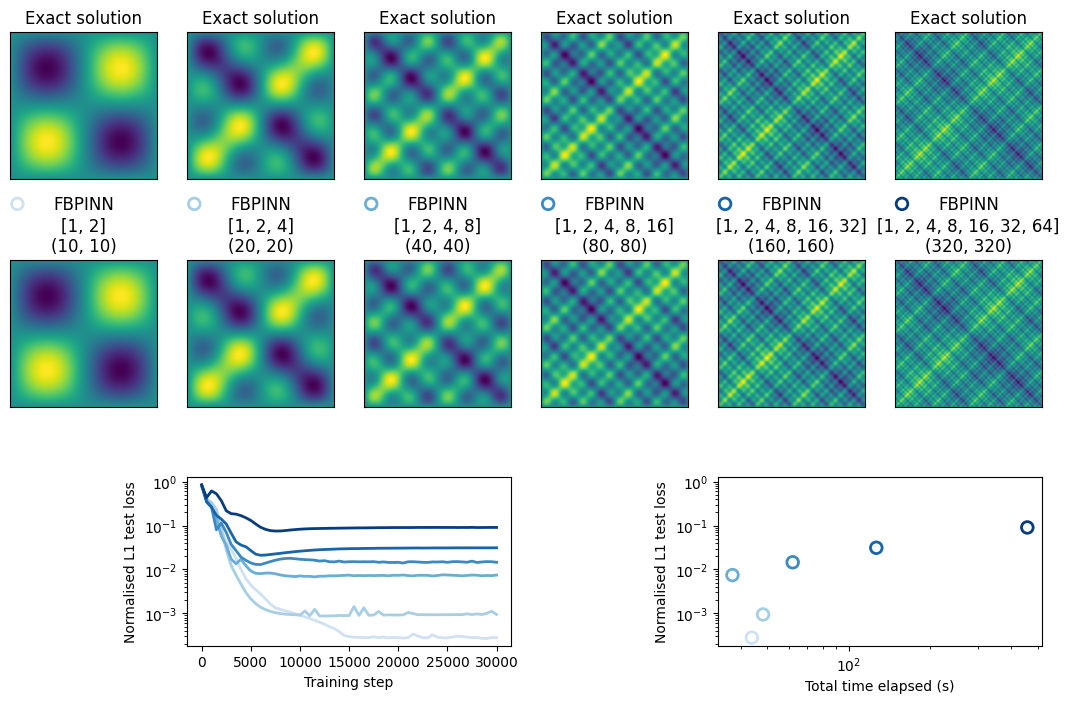

In [6]:
#########
tag = "weak"

#########

h=1
w=1.9
p=16


plt.figure(figsize=0.78*np.array([20,18]))
shape = (5,7)
ax1 = plt.subplot2grid(shape, (2,1), colspan=2)
ax2 = plt.subplot2grid(shape, (2,4), colspan=2)
lx,ly=0.05,1.38
for ip,(l_,n) in enumerate(zip(ls, ns)):
    l = [2**i for i in range(l_)]

    # get exact solution
    network = FCN
    h,p = 1,16
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    u_exact = exact_solution(c, model)

    # plot exact solution
    plt.subplot2grid(shape, (0,ip))
    im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
    plt.title("Exact solution")
    fix_plot4()

    for ir,(network, h, p, label, marker, ic) in enumerate([
        (FCN, 1, 16, f"FBPINN\n{l}\n{n}", "o",0),
        #(SIREN, 1, 16, f"FBPINN (sin)\n{l}\n{n}", "D"),
        #(FCN, 5, 256, f"PINN\n{5}-{256}\n{n}", "s",2),
    ]):

        # load solution
        if label.startswith("FBPINN"):
            c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
            u_test = FBPINN_solution(c, model)
        else:
            c, model, i, t, l1 = load_PINN(tag, problem, network, h, p, n)
            u_test = PINN_solution(c, model)

        # plot convergence
        plt.sca(ax1)
        plt.plot(i, l1, color=colorss[ic][ip], lw=2)
        plt.sca(ax2)
        plt.scatter(t[-1], l1[-1],
                marker=marker, edgecolors=colorss[ic][ip], facecolor="none", s=70, lw=2)

        # plot solution
        plt.subplot2grid(shape, (1+ir,ip))
        plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
        plt.scatter(lx,ly, clip_on=False, 
                    marker=marker, edgecolors=colorss[ic][ip], facecolor="none", s=70, lw=2)
        plt.title(label)
        fix_plot4()

plt.sca(ax1)
fix_plot(legend=False)
ylim = plt.ylim()
plt.sca(ax2)
fix_plot3(legend=False)
plt.ylim(ylim)
plt.subplots_adjust(hspace=0.35, wspace=0.2)
savefig()
plt.show()

## Helmholtz - ablation

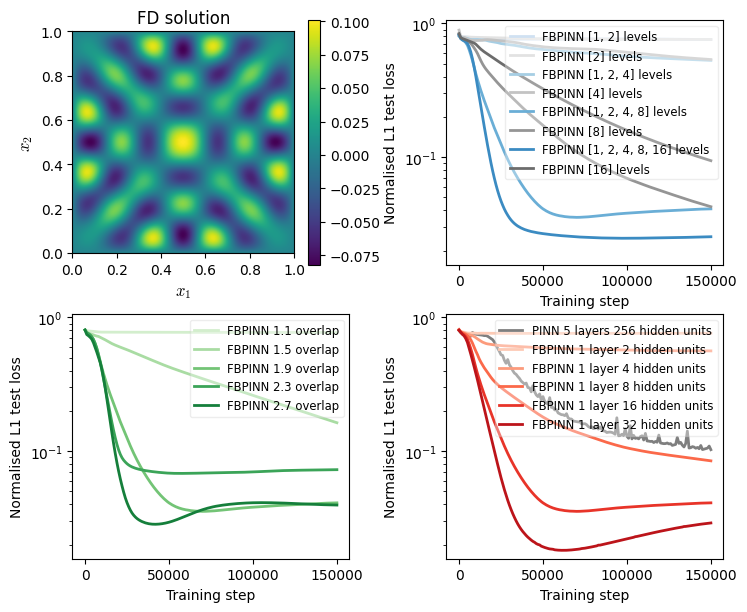

In [7]:
#########

network = FCN

tag = "ablation"

problem=Helmholtz2D
problem_init_kwargs = dict(c=1, w=2*np.pi/(0.2), sd=0.05)
unnorm=(0.00, 0.07)# unnorm

n_steps=150000# number training steps
n=(160,160)# number training points
n_test=(320,320)# number test points

h=1

ls=[2, 3, 4, 5]# number of levels
ws=[1.1, 1.5, 1.9, 2.3, 2.7]# overlap width
ps=[2, 4, 8, 16, 32]# number of hidden units
p0=[4, 1.9, 16]

#########


# plot ablations
plt.figure(figsize=0.7*np.array([12,10]))

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,2)
for ip,l_ in enumerate(ls):
    l = [2**i for i in range(l_)]
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {l} levels ", c=colors1[ip], lw=2)
    if l_ != 0:
        l = [2**(l_-1)]
        c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
        plt.plot(i, l1, label=f"FBPINN {l} levels ", c=colors4[ip], lw=2)
    
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
ylim = list(plt.ylim())
ylim[0] -= 0.5e-2
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,3)
for ip,w in enumerate(ws):
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {w} overlap", c=colors2[ip], lw=2)
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,4)
h,p=5,256
c, model, i, t, l1 = load_PINN(tag, problem, network, h, p, n)
plt.plot(i, l1, label=f"PINN {h} layers {p} hidden units", c="tab:grey", lw=2)
h,p=1,16

for ip,p in enumerate(ps):
    c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
    plt.plot(i, l1, label=f"FBPINN {h} layer {p} hidden units", c=colors3[ip], lw=2)

fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

# plot exact solution
plt.subplot(2,2,1)
u_exact = exact_solution(c, model)
plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.title("FD solution")
fix_plot2()

plt.subplots_adjust(hspace=0.2, wspace=0.35)
savefig()
plt.show()

## Helmholtz - weak scaling

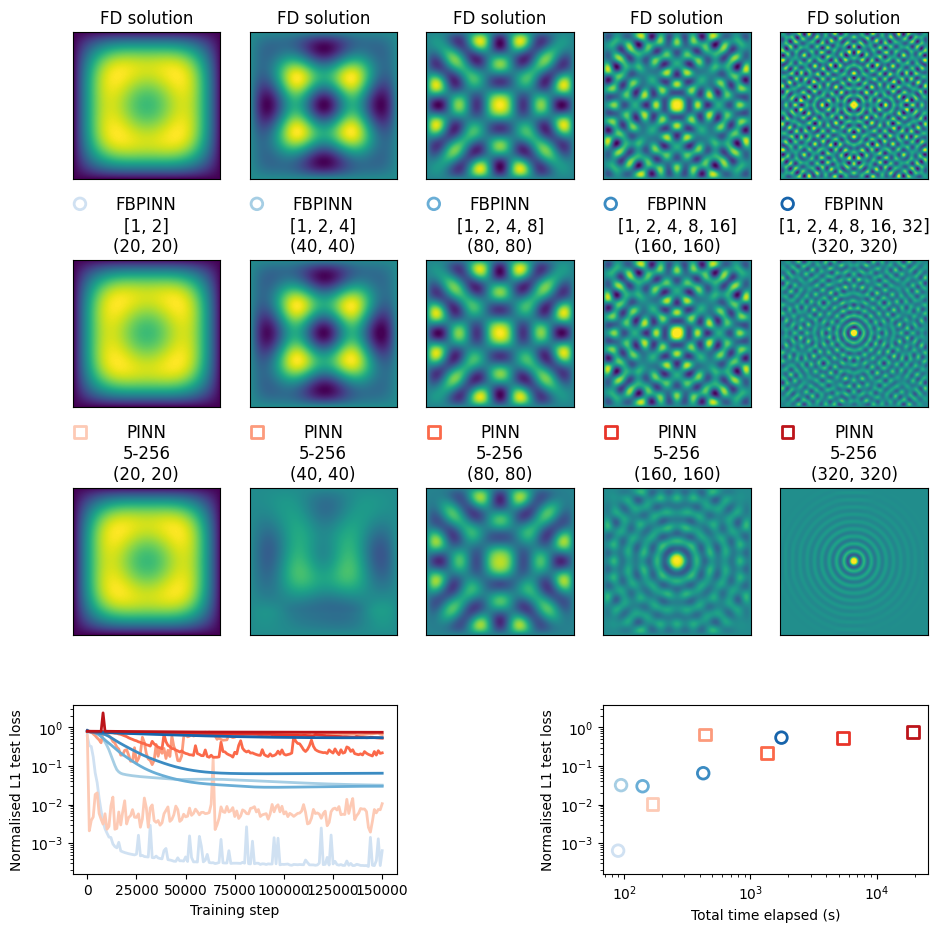

In [8]:
#########

w=1.9

# add omegas to problem, whilst increasing levels and collocation points
ls=[2, 3, 4, 5, 6]# number of levels
ns=[(20,20),(40,40),(80,80),(160,160),(320,320)]# number of collocation points


#########



def plot_weak():
    
    plt.figure(figsize=0.78*np.array([20,18]))
    shape = (5,7)
    ax1 = plt.subplot2grid(shape, (3,0), colspan=2)
    ax2 = plt.subplot2grid(shape, (3,3), colspan=2)
    lx,ly=0.05,1.38
    for ip,(l_,n) in enumerate(zip(ls, ns)):
        l = [2**i for i in range(l_)]
        
        # get exact solution
        network = FCN
        h,p = 1,16
        c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
        u_exact = exact_solution(c, model)
        
        # plot exact solution
        plt.subplot2grid(shape, (0,ip))
        im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
        plt.title("FD solution")
        fix_plot4()
        
        for ir,(network, h, p, label, marker, ic) in enumerate([
            (FCN, 1, 16, f"FBPINN\n{l}\n{n}", "o",0),
            #(SIREN, 1, 16, f"FBPINN (sin)\n{l}\n{n}", "D"),
            (FCN, 5, 256, f"PINN\n{5}-{256}\n{n}", "s",2),
        ]):
            
            # load solution
            if label.startswith("FBPINN"):
                c, model, i, t, l1 = load_FBPINN(tag, problem, network, l, w, h, p, n)
                u_test = FBPINN_solution(c, model)
            else:
                c, model, i, t, l1 = load_PINN(tag, problem, network, h, p, n)
                u_test = PINN_solution(c, model)
    
            # plot convergence
            plt.sca(ax1)
            plt.plot(i, l1, color=colorss[ic][ip], lw=2)
            plt.sca(ax2)
            plt.scatter(t[-1], l1[-1],
                    marker=marker, edgecolors=colorss[ic][ip], facecolor="none", s=70, lw=2)

            # plot solution
            plt.subplot2grid(shape, (1+ir,ip))
            plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
            plt.scatter(lx,ly, clip_on=False, 
                        marker=marker, edgecolors=colorss[ic][ip], facecolor="none", s=70, lw=2)
            plt.title(label)
            fix_plot4()
        
    plt.sca(ax1)
    fix_plot(legend=False)
    ylim = plt.ylim()
    plt.sca(ax2)
    fix_plot3(legend=False)
    plt.ylim(ylim)
    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    savefig()
    plt.show()

for c_ in [1,]:
    tag = f"weak_{c_}"
    plot_weak()